---
## Step 0: Load The Data, standard imports, globals declared

In [26]:
import tensorflow as tf
import numpy as np
BATCH_SIZE = 128
# Load pickled data
import pickle

import os
cwd = os.getcwd()
training_file =  cwd + os.sep +'traffic-signs-data' + os.sep + 'train.p'
validation_file= cwd + os.sep +'traffic-signs-data' + os.sep + 'valid.p'
testing_file =   cwd + os.sep +'traffic-signs-data' + os.sep + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [27]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1 #Assuming training has at least 1 example of each.

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualizations

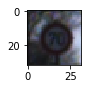

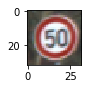

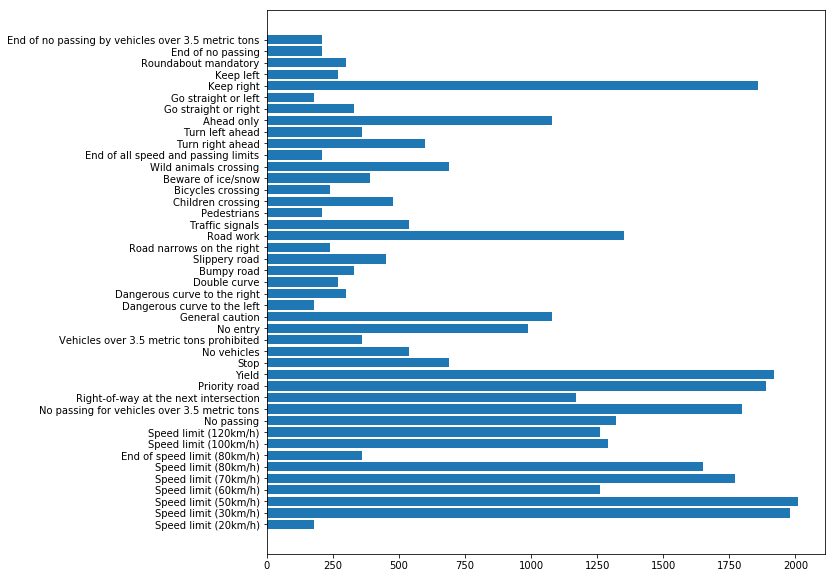

Mean Examples/class: 809.279069767
Median Examples/class: 540.0
Max Examples/class 2010
Min Examples/class 180


In [28]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

random_image = X_train[np.random.randint(0,X_train.shape[0])]
plt.figure(figsize=(1,1))
plt.imshow(random_image)

random_image2 = X_train[np.random.randint(0,X_train.shape[0])]
plt.figure(figsize=(1,1))
plt.imshow(random_image2)


with open(cwd + '/signnames.csv', mode='r', encoding='utf-8') as f:
    label_classes = f.readlines()
classes = [s.split(',')[1].replace('\n','') for s in label_classes][1:]
ypos = np.arange(len(classes))

y_counts = [(y_train == i).sum() for i in range(n_classes)]

plt.figure(figsize=(10,10))
bar = plt.barh(ypos, y_counts)
plt.yticks(ypos, classes)
plt.show()
print("Mean Examples/class:", np.mean(y_counts))
print("Median Examples/class:", np.median(y_counts))
print("Max Examples/class", np.max(y_counts))
print("Min Examples/class", np.min(y_counts))



----

## Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. Although, computing the mean is easy enough anyway.

Images are converted to grayscale as the only other pre-processing step.


In [29]:
def rgb2grayscale(X):
    #OpenCV has no prebuilt for OSX, using backup
    try: 
        import cv2
        gray = np.zeros((len(X), 32,32,1), dtype=np.float32)
        for i in range(0, len(X)):
            gray[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY).reshape(32,32,1)
        return gray
    except ImportError:
        return np.dot(X, [0.3, 0.59, 0.11]).reshape(-1,32,32,1)


In [30]:
#Convert to grayscale
X_train = rgb2grayscale(X_train)
X_valid = rgb2grayscale(X_valid)
X_test  = rgb2grayscale(X_test)

# Visualize the averages of the classes

This compute the average per pixel activation image for each class. The average is actually quite nicely centered and clearly marked. Some of the higher detailed signs are less clear. E.G. No Passing and Vehicles over 3.5 metcis tones prohibited are not easily distinguishable

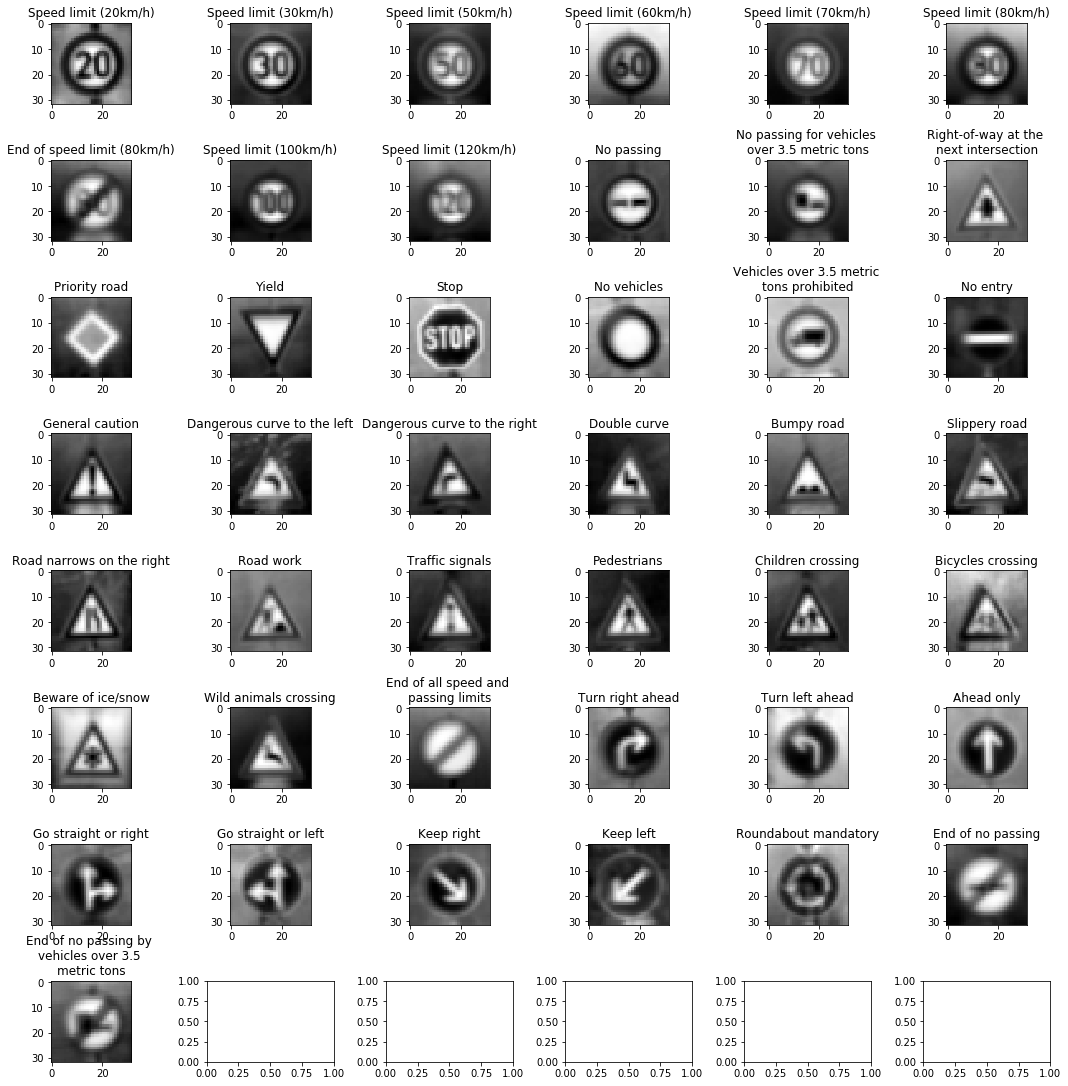

In [31]:
avg_image = np.zeros([43,32,32])
for i in range(n_classes):
    num_in_class = np.sum(y_train == i)
    #print(num_in_class_i)
    X_in_class = X_train[y_train == i]
    #print(X_in_class.shape)
    X_avg = np.sum(X_in_class, axis=0) / num_in_class
    #print(X_avg.shape)
    avg_image[i] = np.squeeze(X_avg)

formatted_classes = list(classes) #copy the text
formatted_classes[10] = 'No passing for vehicles \nover 3.5 metric tons'
formatted_classes[11] = 'Right-of-way at the \nnext intersection'
formatted_classes[16] = 'Vehicles over 3.5 metric \ntons prohibited'
formatted_classes[32] = 'End of all speed and \npassing limits'
formatted_classes[42] = 'End of no passing by \nvehicles over 3.5 \nmetric tons'

f, axarr = plt.subplots(8,6)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout(pad=1.0, w_pad=1.5, h_pad=3.5)
for i in range(8):
    for j in range(6):
        index = i*6 + j
        if(index+1 > n_classes):
            break
        axarr[i,j].imshow(avg_image[index], cmap='gray')
        axarr[i,j].set_title(formatted_classes[index])

In [32]:
# Normalize
mean = np.mean(X_train)
X_train = (X_train - mean)/128.0
X_valid = (X_valid - mean)/128.0
X_test = (X_test - mean)/128.0

In [33]:
#increase number of examples for lower exampled classes
X_tr = X_train
print(X_tr.shape)
y_tr = y_train

y_counts = [(y_tr == i).sum() for i in range(n_classes)]
while min(y_counts) < 500:
    for c in range(n_classes):
        num_ex = sum(y_train == c)
        if num_ex < 1000:
            examples = np.array(X_train[y_train == c])
            examples += np.random.normal(0, 0.0001, examples.shape)
            X_tr = np.concatenate((X_tr, examples), axis=0)
            y_tr = np.concatenate((y_tr, (np.ones(num_ex) * c)), axis=0)
    y_counts = [(y_tr == i).sum() for i in range(n_classes)]

(34799, 32, 32, 1)


In [34]:
#Sanity the data is the same structure
assert len(X_tr) == len(y_tr)
if len(X_tr) == len(y_tr):
    X_train = X_tr
    y_train = y_tr
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)



X_train.shape (55017, 32, 32, 1)
y_train.shape (55017,)


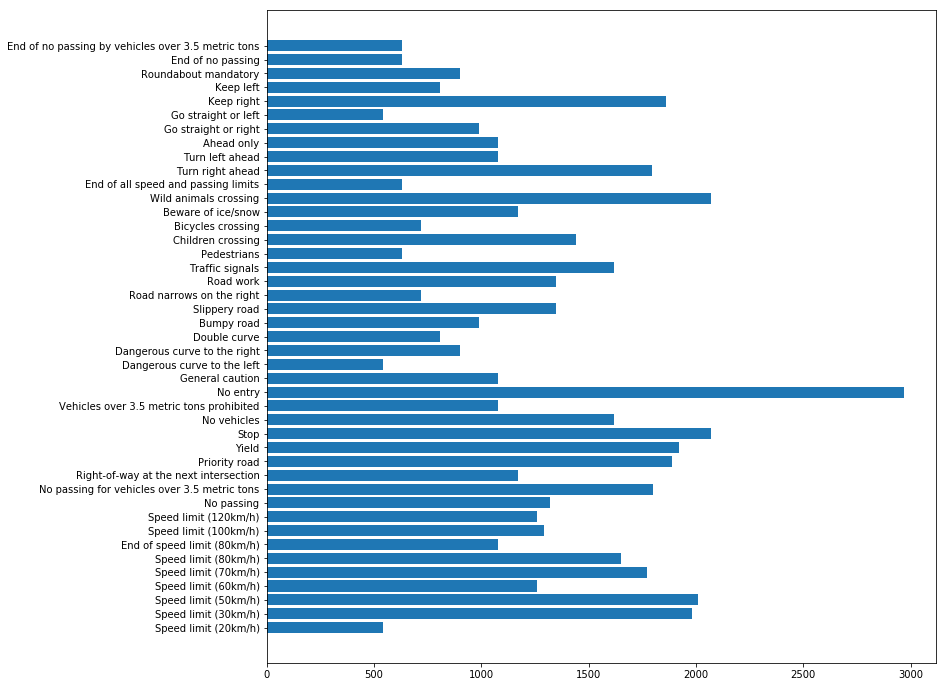

In [35]:
#Let's see the classes again now that we've added a lot more examples
plt.figure(figsize=(12,12))
bar = plt.barh(ypos, y_counts)
plt.yticks(ypos, classes)
plt.show()

In [36]:
def model(X):
    mu = 0.0 
    sigma = 0.25
    padding = 'VALID'
    kernel1 = 12
    kernel2 = 24
    
    #Conv1
    W1 = tf.Variable(tf.truncated_normal([5,5,1,kernel1], mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(kernel1))
    stride1 = [1,1,1,1]
    conv1 = tf.nn.conv2d(x, W1, stride1, padding)
    conv1 = tf.nn.bias_add(conv1, b1)
    
    act1 = tf.nn.relu(conv1)
    
    pool1 = tf.nn.max_pool(act1, [1,2,2,1], [1,2,2,1], padding=padding)
    print(pool1.get_shape())
    
    
    #conv2
    W2 = tf.Variable(tf.truncated_normal([5,5,kernel1,kernel2], mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(kernel2))
    stride2 = [1,1,1,1]
    conv2 = tf.nn.conv2d(pool1, W2, stride2, padding)
    conv2 = tf.nn.bias_add(conv2, b2)
    
    act2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(act2, [1,2,2,1], [1,2,2,1], padding=padding)
    print('pool2', pool2.get_shape())
    
    #Dense 1
    flatten1 = tf.reshape(pool2, [-1, 5*5*kernel2])
    dropout = tf.nn.dropout(flatten1, keep_prob)
    
    W3 = tf.Variable(tf.truncated_normal([5*5*kernel2, 400], mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(400))
    dense1 = tf.matmul(dropout, W3)
    dense1 = tf.nn.bias_add(dense1, b3)
    act3 = tf.nn.relu(dense1)
    
    #Dense 2
    dropout2 = tf.nn.dropout(act3, keep_prob)
    W4 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(120))
    dense2 = tf.matmul(dropout2, W4)
    dense2 = tf.nn.bias_add(dense2, b4)
    act4 = tf.nn.relu(dense2)
    
    #Dense 3
    W5 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(84))
    dense3 = tf.matmul(act4, W5)
    dense3 = tf.nn.bias_add(dense3, b5)
    act5 = tf.nn.relu(dense3)
    
    #Dense 4
    W6 = tf.Variable(tf.truncated_normal([84, 43], mean=mu, stddev=sigma))
    b6 = tf.Variable(tf.zeros(43))
    dense4 = tf.matmul(act5, W6)
    logits = tf.nn.bias_add(dense4, b6)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [37]:
#Place holders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [38]:
rate = 0.008 #This rate had a large effect on training, this only sometimes converges, possibly we'll need to restart
             # 0.01 diverged quickly after 90% accuracy on validation
             # 0.001 fails top converge always

logits = model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 12)
pool2 (?, 5, 5, 24)


In [39]:
index = tf.argmax(logits, 1)
correct_prediction = tf.equal(index, tf.argmax(one_hot_y, 1))
prediction = tf.cast(index, tf.float32)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        pred = sess.run(index, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        #print(pred)
    #print("Accurate out of Num Examples",total_accuracy, num_examples)
    #print("Guess", pred)
    #tf.Print(prediction, [prediction], message="Guess Number")
    return total_accuracy / num_examples

In [38]:
from sklearn.utils import shuffle
EPOCHS = 75
X_train, y_train = shuffle(X_train, y_train)
max_valid_acc = 0
model_file_name = './traffic_signs_extradata2'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        train_accuracy = evaluate(X_train[0:len(y_valid)], y_train[0:len(y_valid)])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        if(validation_accuracy > max_valid_acc):
            max_valid_acc = validation_accuracy
            print("Saving best seen model on epoch #{}".format(i+1))
            #New best model, save this one.
            saver.save(sess, model_file_name)        
    #saver.save(sess, './traffic_signs_extradata2') #Just in case we run this cell, we don't lose the model
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.027
Train Accuracy = 0.052
Saving best seen model on epoch #1
EPOCH 2 ...
Validation Accuracy = 0.035
Train Accuracy = 0.088
Saving best seen model on epoch #2
EPOCH 3 ...
Validation Accuracy = 0.270
Train Accuracy = 0.319
Saving best seen model on epoch #3
EPOCH 4 ...
Validation Accuracy = 0.554
Train Accuracy = 0.584
Saving best seen model on epoch #4
EPOCH 5 ...
Validation Accuracy = 0.624
Train Accuracy = 0.691
Saving best seen model on epoch #5
EPOCH 6 ...
Validation Accuracy = 0.712
Train Accuracy = 0.807
Saving best seen model on epoch #6
EPOCH 7 ...
Validation Accuracy = 0.800
Train Accuracy = 0.855
Saving best seen model on epoch #7
EPOCH 8 ...
Validation Accuracy = 0.820
Train Accuracy = 0.900
Saving best seen model on epoch #8
EPOCH 9 ...
Validation Accuracy = 0.869
Train Accuracy = 0.908
Saving best seen model on epoch #9
EPOCH 10 ...
Validation Accuracy = 0.890
Train Accuracy = 0.937
Saving best seen model on epoch #10
EPOCH

# Testing on new images

## Found images

These images were pulled from Google Street View in the city of Frankfurt.

They were originally pulled as 24x24 (oops) images and scaled up to 32x32

In [48]:
#Mac to Windows EOL markers, Only run this if your data does not work.
#I did this in Notepad++ originally, so it might not work.
#custom_train_file_X =   cwd + '/traffic-signs-data/X_test.p'
#custom_train_file_y =   cwd + '/traffic-signs-data/y_test.p'

with open(custom_train_file_X, mode='r+') as f:
    fixed = f.read().replace('\r\n', '\n')
    f.seek(0)
    f.write(fixed)
    f.truncate()
with open(custom_train_file_y, mode='r+') as f:
    fixed = f.read().replace('\r\n', '\n')
    f.seek(0)
    f.write(fixed)
    f.truncate()


In [40]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from numpy.core import multiarray

custom_train_file_X =   cwd + '/traffic-signs-data/X_test.p'
custom_train_file_y =   cwd + '/traffic-signs-data/y_test.p'


with open(custom_train_file_X, mode='rb') as f:
    custom_X_test = pickle.load(f, encoding='latin-1')
with open(custom_train_file_y, mode='rb') as f:
    custom_y_test = pickle.load(f, encoding='latin1')    
custom_X_test = np.array(custom_X_test)
custom_y_test = np.array(custom_y_test)    


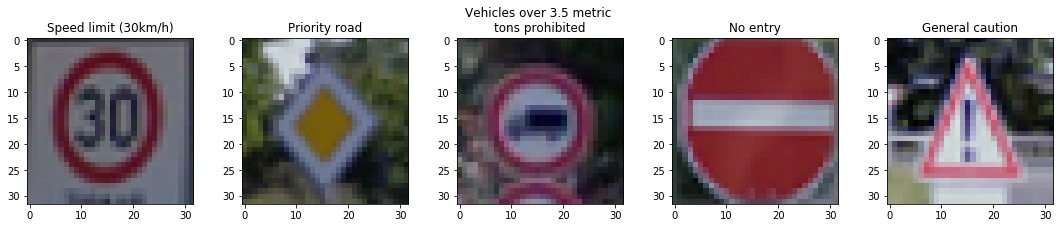

In [41]:
f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout(pad=1.0, w_pad=1.5, h_pad=3.5)
for i in range(5):
    axarr[i].imshow(custom_X_test[i,:])
    axarr[i].set_title(formatted_classes[custom_y_test[i]])

### Predict the Sign Type for Each Image

In [42]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
custom_X_test = rgb2grayscale(custom_X_test)
custom_X_test = (custom_X_test - mean)/128.0

In [43]:
custom_X_test.shape # (5,32,32,1)

(5, 32, 32, 1)

In [44]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './traffic_signs_extradata2')
    test_accuracy = evaluate(custom_X_test, custom_y_test)
    y_test_acc = evaluate(X_test, y_test)
    predicts = sess.run(index, feed_dict={x: custom_X_test, y: custom_y_test, keep_prob: 1.0})
print("Test set accuracy: {:0.3f}%".format(100*y_test_acc))
print("If < 90% there probably was an issue reloading the model, rerun the cells")

INFO:tensorflow:Restoring parameters from ./traffic_signs_extradata2
Test set accuracy: 5.677%


### Analyze Performance

Got 100.000% of the custom test set correct


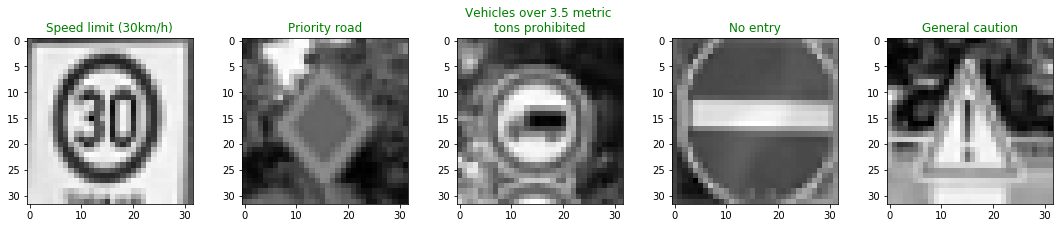

In [169]:
### Calculate the accuracy for these 5 new images. 
print('Got {:.3f}% of the custom test set correct'.format(test_accuracy*100))

f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout(pad=1.0, w_pad=1.5, h_pad=3.5)
for i in range(5):
    color = 'r'
    im = np.squeeze(custom_X_test[i,:])
    axarr[i].imshow(im, cmap='gray')
    if(custom_y_test[i] == predicts[i]):
        color = 'g'
    axarr[i].set_title(formatted_classes[custom_y_test[i]], color=color)
#print(custom_X_test[0,:].shape)    
#custom_y_test

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [47]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.


saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './traffic_signs_extradata2')
    top_k_pred = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: custom_X_test, y: custom_y_test, keep_prob: 1.0})
    #top_k_pred = sess.run(tf.nn.in_top_k(logits, k=5), feed_dict={x: custom_X_test, y: custom_y_test, keep_prob: 1.0})
    
#print(top_k_pred)

print("(Actual Class,    Top 5, Probabilities)")
#print(top_k_pred.indices)
#print([[formatted_classes[i] for i in example] for example in top_k_pred.indices])
for ans in zip(custom_y_test, [zip([classes[i] for i in top_k_pred.indices[ex_i]], top_k_pred.values[ex_i]) for ex_i in range(len(top_k_pred.indices))]):
    print(ans[0])
    for class_prob in list(ans[1]):
        print('\t', class_prob[0]," - {:.5f}%".format(class_prob[1]*100))

INFO:tensorflow:Restoring parameters from ./traffic_signs_extradata2
(Actual Class,    Top 5, Probabilities)
1
	 No passing for vehicles over 3.5 metric tons  - 99.99985%
	 Keep right  - 0.00016%
	 Priority road  - 0.00000%
	 Double curve  - 0.00000%
	 Turn right ahead  - 0.00000%
12
	 No passing for vehicles over 3.5 metric tons  - 99.99963%
	 Pedestrians  - 0.00037%
	 Keep right  - 0.00000%
	 Priority road  - 0.00000%
	 Keep left  - 0.00000%
16
	 No passing for vehicles over 3.5 metric tons  - 100.00000%
	 Double curve  - 0.00000%
	 Turn right ahead  - 0.00000%
	 Priority road  - 0.00000%
	 Keep right  - 0.00000%
17
	 No passing for vehicles over 3.5 metric tons  - 99.99982%
	 Double curve  - 0.00012%
	 Keep right  - 0.00006%
	 Keep left  - 0.00000%
	 Priority road  - 0.00000%
18
	 No passing for vehicles over 3.5 metric tons  - 100.00000%
	 Keep right  - 0.00000%
	 Priority road  - 0.00000%
	 Speed limit (120km/h)  - 0.00000%
	 Pedestrians  - 0.00000%


In [42]:
# Some examples of poorly performing signs
X_data = X_test
y_data = y_test
total_accurate = 0
k=5
num_examples = len(X_data)

top_k_predictions = np.array([]).reshape(0,k)
top_k_predictions_values = np.array([]).reshape(0,k)
#print()
in_top_k_predictions = np.array([]).reshape(0)

with tf.Session() as sess:
    saver.restore(sess, './traffic_signs_extradata2')
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_k_pred = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: batch_x, y: batch_x, keep_prob: 1.0})
        
        top_k_predictions = np.concatenate((top_k_predictions, batch_k_pred.indices), axis=0)
        top_k_predictions_values = np.concatenate((top_k_predictions_values, batch_k_pred.values), axis=0)
        batch_in_top_k_pred = sess.run(tf.nn.in_top_k(logits, tf.argmax(one_hot_y, 1), k=k), feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        
        in_top_k_predictions = np.concatenate((in_top_k_predictions, batch_in_top_k_pred), axis=0)
        total_accurate += sum(batch_in_top_k_pred)
        
print("Test data has top {} accuracy of {:.4f}".format(k, total_accurate / len(X_data)))

INFO:tensorflow:Restoring parameters from ./traffic_signs_extradata2
Test data has top 5 accuracy of 0.9700


(379, 32, 32, 1)
(379, 5)


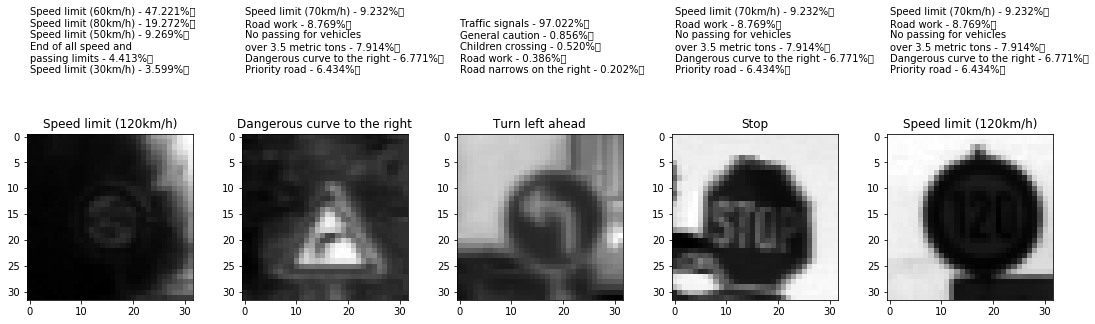

In [140]:
import os
failed_top_k = X_test[(in_top_k_predictions == False)]
failed_top_k_class = y_test[(in_top_k_predictions == False)]
failed_top_k_pred = top_k_predictions[(in_top_k_predictions == False)]
failed_top_k_pred_values = top_k_predictions_values[(in_top_k_predictions == False)]
print(failed_top_k.shape)
print(failed_top_k_pred.shape)

random_indices = np.random.choice(len(failed_top_k), 5)
f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)
f.tight_layout(pad=1.0, w_pad=1.5, h_pad=3.5)
for i in range(5):
    probs = iter(failed_top_k_pred_values[random_i,:])
    #print(next(probs))
    label_raw = [formatted_classes[int(i)]+' - {:.3f}%'.format(next(probs)*100)+os.linesep for i in failed_top_k_pred[random_i,:]]
    label = ''.join(label_raw)
    random_i = random_indices[i]
    img = np.squeeze(failed_top_k[random_i,:])
    axarr[i].imshow(img, cmap='gray')
    axarr[i].set_title(formatted_classes[failed_top_k_class[random_i]])
    axarr[i].annotate(label, (0,0), (0, -10))

# Outputting Notebook
This outputs the notebook as an HTML webpage in the directory

In [48]:
%%bash
jupyter nbconvert --to html Traffic_Sign_Classifier.ipynb
mv Traffic_Sign_Classifier.html $(date +"%m_%d_%Y-%H%M%S")_Traffic_Sign_Classifier.html

[NbConvertApp] Converting notebook Traffic_Sign_Classifier.ipynb to html
[NbConvertApp] Writing 863449 bytes to Traffic_Sign_Classifier.html
